In [1]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import numpy as np
import requests
from scipy import stats
from talib import MACD, RSI, BBANDS
from datetime import datetime, timedelta, date
from IPython.display import display, HTML
%matplotlib inline
import json
import math
from dateutil import parser
from pytz import timezone
import sys

In [2]:
start_day_to_analyze = '2020-04-28'
end_day_to_analyze = '2020-04-29'

In [3]:
db_conn = create_engine("postgresql://momentum@localhost:5432/tradedb")

In [4]:
api = tradeapi.REST(base_url="https://api.alpaca.markets")
session = requests.session()

In [5]:
query = f'''
SELECT * 
FROM 
new_trades as t
WHERE 
    tstamp >= '{start_day_to_analyze}' and 
    tstamp < '{end_day_to_analyze}' 
ORDER BY symbol, tstamp
'''
trades =  pd.read_sql_query(query, db_conn)

In [6]:
query = f'''
SELECT * 
FROM 
algo_run as t
WHERE 
    start_time >= '{start_day_to_analyze}' and 
    start_time < '{end_day_to_analyze}' 
ORDER BY algo_run_id
'''
algo_runs = pd.read_sql_query(query, db_conn)

In [7]:
trades

,trade_id,algo_run_id,symbol,operation,qty,price,indicators,client_time,tstamp,stop_price,target_price
0,2671,428,ERJ,buy,457,5.95,"{'avg': 5.7568, 'rsi': 73.08256919262433, 'mac...",2020-04-28 14:06:33.454449+00:00,2020-04-28 14:06:33.589193,5.75,6.59
1,2674,428,ERJ,sell,457,5.90,"{'avg': 5.8071, 'rsi': [49.52171961663163, 47....",2020-04-28 14:41:05.628928+00:00,2020-04-28 14:41:05.800930,5.75,6.59
2,2669,428,SDC,buy,53,6.71,"{'avg': 6.5914, 'rsi': 68.45830416026276, 'mac...",2020-04-28 13:51:06.570386+00:00,2020-04-28 13:51:06.661816,6.12,8.52
3,2670,428,SDC,buy,106,6.71,"{'avg': 6.5914, 'rsi': 68.45830416026276, 'mac...",2020-04-28 13:51:06.660359+00:00,2020-04-28 13:51:06.848988,6.12,8.52
4,2672,428,SDC,sell,159,6.40,"{'avg': 6.5698, 'rsi': [46.810852290597055, 46...",2020-04-28 14:22:05.559886+00:00,2020-04-28 14:22:05.756500,6.12,8.52
5,2673,428,SDC,buy,236,6.74,"{'avg': 6.5727, 'rsi': 66.72500423628809, 'mac...",2020-04-28 14:35:42.839682+00:00,2020-04-28 14:35:43.052838,6.35,7.97
6,2675,428,SDC,sell,192,6.30,"{'avg': 6.5796, 'rsi': [40.61700746676614, 33....",2020-04-28 14:45:46.497899+00:00,2020-04-28 14:45:46.661781,6.35,7.97
7,2676,428,SDC,sell,44,6.30,"{'avg': 6.5796, 'rsi': [40.61700746676614, 33....",2020-04-28 14:45:46.560152+00:00,2020-04-28 14:45:46.743612,6.35,7.97


In [8]:
trade_details = {}

for index, row in trades.iterrows():
    algo_run_id = row['algo_run_id']
    symbol = row['symbol']
    time = row['tstamp']
    operation = row['operation']
    price = row['price']
    indicators = row['indicators']
    qty = row['qty'] 
    stop_price = row['stop_price']
    target_price = row['target_price']
    if algo_run_id not in trade_details:
        trade_details[algo_run_id] = {}
    if symbol not in trade_details[algo_run_id]:
        trade_details[algo_run_id][symbol] = []
    trade_details[algo_run_id][symbol].append((operation, time, price, qty, indicators, stop_price, target_price))

In [9]:
runs = trades['algo_run_id'].value_counts()
revenues = {}
how_was_my_day = {}

for run_id, count in runs.items():
    symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
    revenues[run_id] = []
    symbol_name = []
    counts = []
    for symbol, count in symbols.items():
        
        revnue = 0
        precentage = 0.0

        for trade in trade_details[run_id][symbol]:
            delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' or trade[0] == 'buy_short' else -1)
            revnue += delta

        revenues[run_id].append(revnue)
        counts.append(count)
        symbol_name.append(symbol)


    d = {
        'symbol': symbol_name,
        'count': counts,
        'revenue': revenues[run_id],
    }
    how_was_my_day[run_id] = pd.DataFrame(data=d)

In [10]:
for algo_id, how_did_i_do in how_was_my_day.items():
    display(HTML(algo_runs.loc[algo_runs['algo_run_id'] == algo_id].to_html()))
    display(HTML(how_did_i_do.round(2).sort_values(by=['revenue']).to_html()))
    print(f'TOTAL REVENUE: {pd.Series(revenues[algo_id]).sum().round(2)} $')


,algo_run_id,algo_name,algo_env,build_number,parameters,start_time,end_time,end_reason
0,428,momentum_long,PAPER,v0.1-346-gcfe1018,"{'DSN': 'postgresql://momentum@10.63.80.3/tradedb', 'TRADE_BUY_WINDOW': 90}",2020-04-28 13:45:01.179438,2020-04-28 20:10:00.493135,market close


,symbol,count,revenue
0,SDC,6,-153.13
1,ERJ,2,-22.85


TOTAL REVENUE: -175.98 $


In [11]:

minute_history = {}
minute_history1 = {}
for run_id, count in runs.items():
    symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
    for symbol, count in symbols.items():
        if symbol not in minute_history:
            minute_history[symbol] = api.polygon.historic_agg_v2(
                symbol, 
                1, 
                'minute',
                _from = (datetime.strptime(start_day_to_analyze, '%Y-%m-%d')-timedelta(days=10)).date(),
                to=(datetime.strptime(end_day_to_analyze, '%Y-%m-%d')+timedelta(days=1)).date()).df
            minute_history1[symbol] = api.polygon.historic_agg_v2(
                symbol, 
                1, 
                'minute',
                _from = (datetime.strptime(start_day_to_analyze, '%Y-%m-%d')-timedelta(days=20)).date(),
                to=(datetime.strptime(end_day_to_analyze, '%Y-%m-%d')-timedelta(days=11)).date()).df

In [ ]:
minute_history['GLOP']

In [ ]:
minute_history1['GLOP']

In [ ]:
m = minute_history1['GLOP'].append(minute_history['GLOP'])

In [ ]:
m[:3976]

In [ ]:
RSI(m[:3976]['close'].dropna().between_time("9:30", "16:00"))

In [12]:
def grouper(iterable):
    prev = None
    group = []
    for item in iterable:
        
        if not prev or -0.02 <= float(item - prev) / prev <= 0.02:
            group.append(item)
        else:
            yield group
            group = [item]
        prev = item
    if group:
        yield group

def find_resistance(current_value, minute_history, now):
    """calculate next resistance"""
    now = pd.Timestamp(now) - timedelta(hours=4)
    print(f"now={now}")
    
    #print(minute_history)
    minute_history_index = minute_history["close"].index.get_loc(now, method='nearest')
    #print(f'index:{minute_history_index} data:{minute_history["close"][minute_history_index]}')
    for back_track_min in range(200, len(minute_history.index), 60):
        #print("start")
        series = (
            minute_history["close"][-back_track_min:minute_history_index].dropna().resample("5min").max()
        ).dropna()
        #print(series[0:10])
        # tlog(f"{symbol} find_resistances(): {len(series)}")

        diff = np.diff(series.values)
        #print(diff)
        high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
        #print(high_index)
        if len(high_index) > 0:
            local_maximas = sorted(
                [series[i] for i in high_index if series[i] >= current_value]
            )
            #print(f"local_maximas={local_maximas}")
            if len(local_maximas) > 0:
                return local_maximas
            continue
            
            clusters = dict(enumerate(grouper(local_maximas), 1))
            #print(f"cluster={clusters}")
            resistances = []
            for key, cluster in clusters.items():
                if len(cluster) > 1:
                    resistances.append(round(sum(cluster) / len(cluster), 2))
            resistances = sorted(resistances)

            if len(resistances) > 0:
                return resistances


    return None

def find_support(current_value, minute_history, now):
    """calculate support"""
    now = pd.Timestamp(now) - timedelta(hours=4)
    minute_history_index = minute_history["close"].index.get_loc(now, method='nearest')
    for back_track_min in range(200, len(minute_history.index), 60):
        series = (minute_history["close"][-back_track_min:minute_history_index].resample("5min").min()).dropna()
        diff = np.diff(series.values)
        high_index = np.where((diff[:-1] <= 0) & (diff[1:] > 0))[0] + 1
        if len(high_index) > 0:
            local_maximas = sorted(
                [series[i] for i in high_index if series[i] <= current_value]
            )
            if len(local_maximas) > 0:
                return local_maximas
            
    return None

now=2020-04-28 09:51:06.661816
now=2020-04-28 09:51:06.848988
now=2020-04-28 10:35:43.052838
SDC analysis for run 428 with profit -153.13


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-355.63,-355.63,buy,2020-04-28 13:51:06.661816,6.71,"[5.2299, 5.24, 5.24, 5.24, 5.24, 5.25, 5.25, 5.25, 5.2767, 5.28, 5.3, 5.36, 5.3902, 5.41, 5.41, 5.42, 5.42, 5.44, 5.45, 5.46]",None,53,"{'avg': 6.5914, 'rsi': 68.45830416026276, 'macd': [0.19305868304342688, 0.20400163282857164, 0.20172272872486996, 0.21175808615103087, 0.21724723414986347], 'vwap': 6.7268, 'supports': [6.17, 6.2894, 6.4002], 'sell_macd': [0.11300392772721057, 0.11982953680345787, 0.1180387187225671, 0.12430511088391771, 0.1275996358033602], 'slow macd': [0.13646218816924538, 0.1425259809527768, 0.14616719777448584, 0.15211432736890984, 0.15735058801956736], 'macd_signal': [0.21202502222652372, 0.2104203443469333, 0.20868082122252063, 0.20929627420822267, 0.21088646619655083], 'resistances': [6.9, 7.08, 7.09, 7.23, 7.23, 7.28, 7.29], 'sell_macd_signal': [0.12775769427430994, 0.12617206278013954, 0.12454539396862505, 0.12449733735168358, 0.12511779704201892]}",8.52,6.12
1,-1066.89,-711.26,buy,2020-04-28 13:51:06.848988,6.71,"[5.2299, 5.24, 5.24, 5.24, 5.24, 5.25, 5.25, 5.25, 5.2767, 5.28, 5.3, 5.36, 5.3902, 5.41, 5.41, 5.42, 5.42, 5.44, 5.45, 5.46]",None,106,"{'avg': 6.5914, 'rsi': 68.45830416026276, 'macd': [0.19305868304342688, 0.20400163282857164, 0.20172272872486996, 0.21175808615103087, 0.21724723414986347], 'vwap': 6.7268, 'supports': [6.17, 6.2894, 6.4002], 'sell_macd': [0.11300392772721057, 0.11982953680345787, 0.1180387187225671, 0.12430511088391771, 0.1275996358033602], 'slow macd': [0.13646218816924538, 0.1425259809527768, 0.14616719777448584, 0.15211432736890984, 0.15735058801956736], 'macd_signal': [0.21202502222652372, 0.2104203443469333, 0.20868082122252063, 0.20929627420822267, 0.21088646619655083], 'resistances': [6.9, 7.08, 7.09, 7.23, 7.23, 7.28, 7.29], 'sell_macd_signal': [0.12775769427430994, 0.12617206278013954, 0.12454539396862505, 0.12449733735168358, 0.12511779704201892]}",8.52,6.12
2,-49.29,1017.60,sell,2020-04-28 14:22:05.756500,6.40,None,None,159,"{'avg': 6.5698, 'rsi': [46.810852290597055, 46.06749680683028], 'vwap': 6.4051, 'reasons': 'below cost & macd negative & RSI trending down', 'movement': -0.0451862891207154, 'sell_macd': [0.012990595276314743, 0.011314602970501575, 0.006001951784536885, 0.0012647956424274298, -0.0031286350610661984], 'sell_macd_signal': [0.02472090187333394, 0.022039642092767465, 0.01883210403112135, 0.015318642353382567, 0.011629186870492813]}",8.52,6.12
3,-1639.93,-1590.64,buy,2020-04-28 14:35:43.052838,6.74,"[5.2299, 5.24, 5.24, 5.24, 5.24, 5.25, 5.25, 5.25, 5.2767, 5.28, 5.3, 5.36, 5.3902, 5.41, 5.41, 5.42, 5.42, 5.44, 5.45, 5.46]",None,236,"{'avg': 6.5727, 'rsi': 66.72500423628809, 'macd': [0.011976624709654438, 0.024918451716824386, 0.03317864721569741, 0.04405853090039091, 0.05646802916161331], 'vwap': 6.755, 'supports': [6.17, 6.2894, 6.3, 6.36], 'sell_macd': [0.004750469502411647, 0.013373608774741363, 0.018880293808053672, 0.02604290170663326, 0.034143077969076785], 'slow macd': [0.08890216894252312, 0.08959301113493545, 0.08976544449767054, 0.09074013757630439, 0.09237140835744384], 'macd_signal': [0.005895748518954916, 0.009700289158528809, 0.01439596076996253, 0.020328474796048206, 0.027556385669161226], 'resistances': [6.9, 7.23, 7.23, 7.29], 'sell_macd_signal': [-0.00046647802575282, 0.002301539334346017, 0.005617290229087548, 0.00970241252459669, 0.014590545613492708]}",7.97,6.35
4,-430.33,1209.60,sell,2020-04-28 14:45:46.661781,6.30,None,None,192,"{'avg': 6.5796, 'rsi': [40.61700746676614, 33.50310335403534], 'vwap': 6.3442, 'reasons': 'stopped', 'movement': -0.059035608308605325, 'sell_macd': [0.035395416160350024, 0.03081286664047589, 0.026327596019268817, 0.015217935846649766, -0.00028073358456826014], 'sell_macd_signal': [0.03313945613238211, 0.032674138234000866, 0.03140482979105445, 0.028167451002173514, 0.02247781408482516]}",7.97,6.35
5,-153.13,277.20,sell,2020-04-28 14:45:46.743612,6.30,N

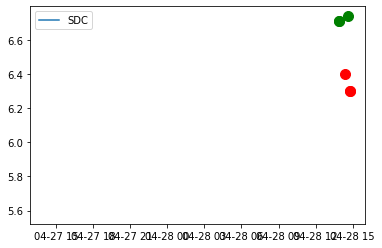

now=2020-04-28 10:06:33.589193
ERJ analysis for run 428 with profit -22.85


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2719.15,-2719.15,buy,2020-04-28 14:06:33.589193,5.95,[5.7601],"[6.05, 6.05, 6.1]",457,"{'avg': 5.7568, 'rsi': 73.08256919262433, 'macd': [0.03539069687355223, 0.03679887473224763, 0.042667972772738594, 0.04997090744522836, 0.05591285446845884], 'vwap': 5.9599, 'supports': [5.34, 5.41, 5.41, 5.42, 5.43, 5.45, 5.46, 5.46, 5.47, 5.55, 5.59, 5.6, 5.7601], 'sell_macd': [0.018309984737929774, 0.019324544952792344, 0.023240766614336827, 0.02806846184912093, 0.031980062527535935], 'slow macd': [0.05416656860090718, 0.054499139599274216, 0.05575753596426569, 0.05746586858801184, 0.05910401728568804], 'macd_signal': [0.05035919604454473, 0.04764713178208531, 0.046651299980215964, 0.04731522147321844, 0.04903474807226652], 'resistances': [6.05, 6.05, 6.1], 'sell_macd_signal': [0.02808309467434663, 0.026331384730035774, 0.025713261106895986, 0.026184301255340974, 0.027343453509779965]}",6.59,5.75
1,-22.85,2696.30,sell,2020-04-28 14:41:05.800930,5.90,None,None,457,"{'avg': 5.8071, 'rsi': [49.52171961663163, 47.721744357743304], 'vwap': 5.9, 'reasons': 'below cost & macd negative & RSI trending down', 'movement': -0.008403361344537785, 'sell_macd': [0.0016772190518672403, 0.0009326878092084101, 8.068050571896634e-05, -0.00025699636071063736, -0.0008440563038938365], 'sell_macd_signal': [0.005487932490308066, 0.004576883554088135, 0.003677642944414301, 0.0028907150833893135, 0.0021437608059326836]}",6.59,5.75


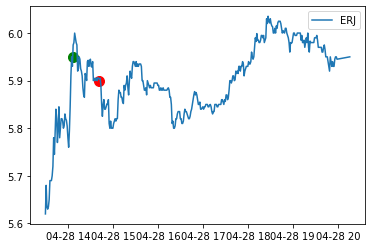

In [13]:
for run_id, count in runs.items():
    for symbol in minute_history:    
        if symbol not in trade_details[run_id]:
            continue
        start_date = datetime.strptime(start_day_to_analyze, "%Y-%m-%d") + timedelta(hours=9, minutes=30)
        minute_history_index = minute_history[symbol]["close"].index.get_loc(start_date, method='nearest')
        plt.plot(minute_history[symbol]["close"][minute_history_index:], label=symbol)

        delta = 0
        profit = 0
        
        operations = []
        deltas = []
        profits = []
        times = []
        prices = []
        qtys = []
        indicators = []
        target_price = []
        stop_price = []
        resistances = []
        supports = []
        for trade in trade_details[run_id][symbol]:
            resistance = None
            support = None
            if trade[0] == 'buy':
                resistance = find_resistance(trade[2], minute_history[symbol], trade[1])
                support = find_support(trade[2], minute_history[symbol], trade[1])
                
            delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' or trade[0] == 'buy_short' else -1)
            profit += delta
            plt.scatter(pd.to_datetime(trade[1]), trade[2], c='g' if trade[0] == 'buy' or trade[0] == 'sell_short' else 'r', s=100)
            deltas.append(round(delta, 2))
            profits.append(round(profit, 2))
            operations.append(trade[0])
            times.append(pd.to_datetime(trade[1]))
            prices.append(trade[2])
            qtys.append(trade[3])
            indicators.append(trade[4])
            target_price.append(trade[6])
            stop_price.append(trade[5])    
            resistances.append(resistance)
            supports.append(support)
        d = {
            'profit': profits,
            'trade': deltas,
            'operation': operations,
            'at': times,
            'price': prices,
            'support': supports,
            'resistance': resistances,
            'qty': qtys,
            'indicators': indicators,
            'target price': target_price,
            'stop price': stop_price
        }   
        print (f'{symbol} analysis for run {run_id} with profit {round(profit, 2)}')
        display(HTML(pd.DataFrame(data=d).to_html()))
        plt.legend()
        plt.show()

SDC analysis for run 428
operation buy price 6.71 qty 53


TypeError: object of type 'Timestamp' has no len()

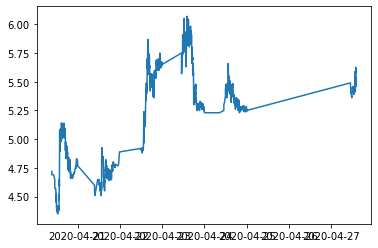

In [14]:
for run_id, count in runs.items():
    for symbol in minute_history:
        if symbol not in trade_details[run_id]:
            print(symobl)
            continue
           
        print (f'{symbol} analysis for run {run_id}')
        plt.plot(minute_history[symbol]['close'], label=symbol)

        for trade in trade_details[run_id][symbol]:
            print(f'operation {trade[0]} price {trade[2]} qty {trade[3]}')

            plt.scatter(parser.isoparse(trade[1]), trade[2], c='g' if trade[0] == 'buy' else 'r', s=100)
    
        plt.legend()
        plt.show()

        min_time = trade_details[run_id][symbol][0][0]
        max_time = trade_details[run_id][symbol][-1][2]
        delta = 0 
        accumulative_delta = []
        
  #      if min_time not in minute_history[symbol]['close'] or max_time not in minute_history[symbol]['close']:
  #          continue
        plt.plot(minute_history[symbol]['close'][min_time:max_time], label=symbol)
                

        for trade in trade_details[run_id][symbol]:
 #           if trade[1] < high_15m[symbol]:
 #               continue
 #           t = parser.isoparse(trade[0])
 #           t = t - timedelta(seconds=t.second, microseconds=t.microsecond)
 #           if trade[1] < minute_history[symbol]['open'][pd.Timestamp(t)]:
 #               continue 

                
            plt.scatter(parser.isoparse(trade[0]), trade[1], c='g', s=100)
            plt.scatter(parser.isoparse(trade[2]), trade[3], c='r', s=100)
            trade_delta = trade[3] - trade[1]
            delta += trade_delta 
            accumulative_delta.append(delta)
            
        plt.legend()
        plt.show()

        print(f'Delta = {delta}')
        plt.plot(range(len(accumulative_delta)), accumulative_delta)
        plt.show()

        for trade in trade_details[run_id][symbol]:
 #           if trade[1] < high_15m[symbol]:
 #               continue
#            t = parser.isoparse(trade[0])
#            t = t - timedelta(seconds=t.second, microseconds=t.microsecond)
#            if trade[1] < minute_history[symbol]['open'][pd.Timestamp(t)]:
#                continue

                
            plt.plot(minute_history[symbol]['close'][trade[0]:trade[2]])
            plt.scatter(parser.isoparse(trade[0]), trade[1], c='g', s=100)
            plt.scatter(parser.isoparse(trade[2]), trade[3], c='r', s=100)
            plt.show()
            print(f"buy time:{trade[0]} sell time:{trade[2]}")
            print(trade[4])
            print(trade[5])



In [ ]:
 pd.Timestamp('2020-04-16 13:44:06.066') 

In [ ]:
index = minute_history['NURO'].index.get_loc(pd.Timestamp('2020-04-16 13:44:06.066') , method='nearest')

In [ ]:
minute_history['NURO'][:index]

In [ ]:
series = minute_history['NURO'][:2417]['close']

In [ ]:
MACD(series.dropna().between_time("9:30", "16:00"))